In [2]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our custom model with explicit reload
import importlib
if 'models' in sys.modules:
    importlib.reload(sys.modules['models'])
import models
from models import MultiModalPlayPredictor

print("🏈 DEEP LEARNING PLAY PREDICTION MODEL")
print("=" * 50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Check for CUDA, Apple Silicon (MPS), or fallback to CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Test model to ensure it works with fixed architecture
print("\n🧪 Testing model architecture...")
test_model = MultiModalPlayPredictor(num_formation_features=55, num_classes=2)
dummy_image = torch.randn(2, 3, 224, 224)
dummy_features = torch.randn(2, 55)
try:
    test_outputs = test_model(dummy_image, dummy_features)
    print("✅ Model architecture test passed!")
    print(f"Output shapes: {[f'{k}: {v.shape}' for k, v in test_outputs.items()]}")
except Exception as e:
    print(f"❌ Model architecture test failed: {e}")
del test_model  # Clean up


🏈 DEEP LEARNING PLAY PREDICTION MODEL
PyTorch version: 2.7.1
CUDA available: False
Using device: mps

🧪 Testing model architecture...
✅ Model architecture test passed!
Output shapes: ['play_type: torch.Size([2, 2])', 'personnel: torch.Size([2, 5])', 'width: torch.Size([2, 1])']


In [3]:
# DATA LOADING AND PREPARATION
print("\n📊 LOADING DATA")
print("-" * 30)

# Load the features we extracted
features_path = "../data/processed/comprehensive_features_labeled.csv"
if Path(features_path).exists():
    df = pd.read_csv(features_path)
    print(f"Loaded features: {df.shape}")
else:
    # Fallback to original features
    features_path = "../data/processed/comprehensive_features.csv"
    df = pd.read_csv(features_path)
    print(f"Loaded features: {df.shape}")

# Filter to only run/pass plays (remove unknown/other labels)
df_clean = df[df['play_type'].isin(['run', 'pass'])].copy()
print(f"After filtering run/pass: {df_clean.shape}")

# Display class distribution
print(f"\n🎯 Class Distribution:")
class_counts = df_clean['play_type'].value_counts()
print(class_counts)
print(f"Balance ratio: {class_counts.min() / class_counts.max():.2f}")

# Select numerical features for the model
feature_columns = [col for col in df_clean.columns 
                  if col not in ['filename', 'play_type', 'dataset_split', 'source_folder', 
                                'prediction_confidence', 'similarity_score'] 
                  and df_clean[col].dtype in ['int64', 'float64']]

print(f"\n🔢 Selected {len(feature_columns)} numerical features")
print("Sample features:", feature_columns[:10])

# Handle missing values
df_clean[feature_columns] = df_clean[feature_columns].fillna(0)

# Create label encoding
label_map = {'run': 0, 'pass': 1}
df_clean['label'] = df_clean['play_type'].map(label_map)

print(f"\n✅ Data preparation complete!")
print(f"Features shape: {df_clean[feature_columns].shape}")
print(f"Labels: {df_clean['label'].value_counts().to_dict()}")



📊 LOADING DATA
------------------------------
Loaded features: (346, 69)
After filtering run/pass: (346, 69)

🎯 Class Distribution:
play_type
run     184
pass    162
Name: count, dtype: int64
Balance ratio: 0.88

🔢 Selected 55 numerical features
Sample features: ['personnel', 'rb_count', 'te_count', 'wr_count', 'qb_count', 'formation_width', 'backfield_depth', 'defense_count', 'box_defenders', 'formation_center_x']

✅ Data preparation complete!
Features shape: (346, 55)
Labels: {0: 184, 1: 162}


In [5]:
# CUSTOM DATASET CLASS
class FootballFormationDataset(Dataset):
    def __init__(self, dataframe, feature_columns, image_base_paths, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.feature_columns = feature_columns
        self.image_base_paths = image_base_paths  # List of possible image directories
        self.transform = transform
        
        # Standardize features
        self.features = torch.FloatTensor(self.df[feature_columns].values)
        self.labels = torch.LongTensor(self.df['label'].values)
        
        # Find image paths
        self.image_paths = []
        for _, row in self.df.iterrows():
            image_path = self._find_image_path(row['filename'], row.get('dataset_split', 'unknown'))
            self.image_paths.append(image_path)
    
    def _find_image_path(self, filename, split):
        """Find the actual path to the image file"""
        possible_paths = []
        
        # YouTube screenshots
        possible_paths.append(Path("../data/youtube_screenshots") / filename)
        
        # Training data paths
        for base_path in self.image_base_paths:
            possible_paths.append(Path(base_path) / filename)
            possible_paths.append(Path(base_path).parent / "images" / filename)
            possible_paths.append(Path(base_path) / split / "images" / filename)
        
        # Find existing path
        for path in possible_paths:
            if path.exists():
                return str(path)
        
        # If no image found, return None
        return None
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        if image_path and Path(image_path).exists():
            try:
                image = Image.open(image_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
            except Exception as e:
                # Create dummy image if loading fails
                image = torch.zeros(3, 224, 224)
        else:
            # Create dummy image if path doesn't exist
            image = torch.zeros(3, 224, 224)
        
        # Get features and label
        features = self.features[idx]
        label = self.labels[idx]
        
        return {
            'image': image,
            'features': features,
            'label': label,
            'filename': self.df.iloc[idx]['filename']
        }

# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define image base paths to search
image_base_paths = [
    "../data/train",
    "../data/valid", 
    "../data/test",
    "../data/original/train",
    "../data/original/valid",
    "../data/original/test",
    "../data/youtube_screenshots"
]

print("📁 Image search paths configured")
print("🖼️ Transforms defined for training and validation")


📁 Image search paths configured
🖼️ Transforms defined for training and validation


In [6]:
# TRAIN/VALIDATION SPLIT
print("\n🔄 CREATING TRAIN/VALIDATION SPLITS")
print("-" * 40)

# Use stratified split to maintain class balance
X = df_clean[feature_columns]
y = df_clean['label']

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df_clean, df_clean['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df_clean['label']
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Train class distribution: {y_train.value_counts().to_dict()}")
print(f"Val class distribution: {y_val.value_counts().to_dict()}")

# Create datasets
train_dataset = FootballFormationDataset(
    X_train, feature_columns, image_base_paths, transform=train_transform
)
val_dataset = FootballFormationDataset(
    X_val, feature_columns, image_base_paths, transform=val_transform
)

# Create data loaders
batch_size = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2 if torch.cuda.is_available() else 0
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2 if torch.cuda.is_available() else 0
)

print(f"✅ DataLoaders created with batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loading
print("\n🧪 Testing data loading...")
sample_batch = next(iter(train_loader))
print(f"Sample batch shapes:")
print(f"  Images: {sample_batch['image'].shape}")
print(f"  Features: {sample_batch['features'].shape}")
print(f"  Labels: {sample_batch['label'].shape}")
print(f"  Sample filenames: {sample_batch['filename'][:3]}")



🔄 CREATING TRAIN/VALIDATION SPLITS
----------------------------------------
Training samples: 276
Validation samples: 70
Train class distribution: {0: 147, 1: 129}
Val class distribution: {0: 37, 1: 33}
✅ DataLoaders created with batch size: 16
Training batches: 18
Validation batches: 5

🧪 Testing data loading...
Sample batch shapes:
  Images: torch.Size([16, 3, 224, 224])
  Features: torch.Size([16, 55])
  Labels: torch.Size([16])
  Sample filenames: ['pass_0002_540.jpg', '58163_000542_Sideline_frame0662_jpg.rf.11de26c2f1def8ed5a34445b5a9a74c4.jpg', '57969_000592_Sideline_frame103_jpg.rf.df0e16a15d5bd828bfd9ef5f3a1483d0.jpg']


In [7]:
# MODEL INITIALIZATION
print("\n🧠 INITIALIZING MODEL")
print("-" * 30)

# Initialize the multimodal model
num_formation_features = len(feature_columns)
num_classes = 2  # run vs pass

model = MultiModalPlayPredictor(
    num_formation_features=num_formation_features,
    num_classes=num_classes
)

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model input features: {num_formation_features}")

# Define loss functions and optimizer
criterion_main = nn.CrossEntropyLoss()
criterion_personnel = nn.MSELoss()  # For personnel prediction
criterion_width = nn.MSELoss()     # For width prediction

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print(f"✅ Loss functions and optimizer configured")
print(f"Learning rate: 0.001")
print(f"Weight decay: 0.01")

# Training configuration
num_epochs = 25
early_stopping_patience = 10
best_val_acc = 0.0
patience_counter = 0

print(f"\n📋 Training Configuration:")
print(f"Epochs: {num_epochs}")
print(f"Early stopping patience: {early_stopping_patience}")
print(f"Device: {device}")

# Initialize tracking lists
train_losses = []
val_losses = []
train_accs = []
val_accs = []



🧠 INITIALIZING MODEL
------------------------------
Model initialized successfully!
Total parameters: 5,046,148
Trainable parameters: 5,046,148
Model input features: 55
✅ Loss functions and optimizer configured
Learning rate: 0.001
Weight decay: 0.01

📋 Training Configuration:
Epochs: 25
Early stopping patience: 10
Device: mps


In [8]:
# TRAINING FUNCTIONS
def train_epoch(model, train_loader, criterion_main, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, batch in enumerate(train_loader):
        images = batch['image'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, features)
        
        # Calculate main loss (play type prediction)
        loss_main = criterion_main(outputs['play_type'], labels)
        
        # Multi-task learning: add auxiliary losses with proper target construction
        # For personnel prediction: create target from multiple personnel features
        personnel_targets = torch.stack([
            features[:, feature_columns.index('rb_count')] if 'rb_count' in feature_columns else torch.zeros(features.shape[0], device=device),
            features[:, feature_columns.index('te_count')] if 'te_count' in feature_columns else torch.zeros(features.shape[0], device=device),
            features[:, feature_columns.index('wr_count')] if 'wr_count' in feature_columns else torch.zeros(features.shape[0], device=device),
            features[:, feature_columns.index('qb_count')] if 'qb_count' in feature_columns else torch.zeros(features.shape[0], device=device),
            features[:, feature_columns.index('defense_count')] if 'defense_count' in feature_columns else torch.zeros(features.shape[0], device=device)
        ], dim=1)
        
        loss_personnel = criterion_personnel(outputs['personnel'], personnel_targets)
        
        # For width prediction: use formation_width as target
        width_targets = features[:, feature_columns.index('formation_width')] if 'formation_width' in feature_columns else torch.zeros(features.shape[0], device=device)
        loss_width = criterion_width(outputs['width'].squeeze(), width_targets)
        
        # Combined loss with weights (reduced auxiliary weights to focus on main task)
        total_loss = loss_main + 0.05 * loss_personnel + 0.05 * loss_width
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += total_loss.item()
        _, predicted = torch.max(outputs['play_type'], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Progress update
        if batch_idx % 10 == 0:
            print(f'  Batch {batch_idx:3d}/{len(train_loader):3d} | '
                  f'Loss: {total_loss.item():.4f} | '
                  f'Acc: {100.*correct/total:.1f}%', end='\\r')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion_main, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(images, features)
            
            # Calculate loss
            loss = criterion_main(outputs['play_type'], labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs['play_type'], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store for metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_predictions, all_labels

print("🔧 Training functions defined")
print("✅ Ready to start training!")


🔧 Training functions defined
✅ Ready to start training!


In [9]:
# TRAINING LOOP
print("\n🚀 STARTING TRAINING")
print("=" * 50)

for epoch in range(num_epochs):
    print(f"\\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion_main, optimizer, device
    )
    
    # Validation
    val_loss, val_acc, val_predictions, val_labels = validate_epoch(
        model, val_loader, criterion_main, device
    )
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Print epoch results
    print(f"\\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
        }, '../models/best_play_predictor.pth')
        
        print(f"✅ New best model saved! Accuracy: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{early_stopping_patience}")
        
        if patience_counter >= early_stopping_patience:
            print(f"\\n🛑 Early stopping triggered after {epoch+1} epochs")
            break

print(f"\\n🎉 TRAINING COMPLETE!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved to: ../models/best_play_predictor.pth")



🚀 STARTING TRAINING
\nEpoch 1/25
------------------------------
  Batch   0/ 18 | Loss: 1729.1550 | Acc: 43.8%\r  Batch  10/ 18 | Loss: 2894.9919 | Acc: 51.7%\r\nTrain Loss: 3096.8375 | Train Acc: 54.71%
Val Loss:   0.7386 | Val Acc:   47.14%
✅ New best model saved! Accuracy: 47.14%
\nEpoch 2/25
------------------------------
  Batch   0/ 18 | Loss: 2571.8445 | Acc: 56.2%\r  Batch  10/ 18 | Loss: 1625.9095 | Acc: 54.0%\r\nTrain Loss: 3192.0278 | Train Acc: 53.26%
Val Loss:   0.7391 | Val Acc:   47.14%
⏳ No improvement. Patience: 1/10
\nEpoch 3/25
------------------------------
  Batch   0/ 18 | Loss: 2172.9238 | Acc: 50.0%\r  Batch  10/ 18 | Loss: 2883.7969 | Acc: 43.8%\r\nTrain Loss: 3100.3677 | Train Acc: 50.00%
Val Loss:   0.7247 | Val Acc:   51.43%
✅ New best model saved! Accuracy: 51.43%
\nEpoch 4/25
------------------------------
  Batch   0/ 18 | Loss: 3276.9297 | Acc: 50.0%\r  Batch  10/ 18 | Loss: 3362.4233 | Acc: 48.9%\r\nTrain Loss: 3075.1534 | Train Acc: 49.28%
Val Loss:  

\n📊 VISUALIZING TRAINING RESULTS
----------------------------------------


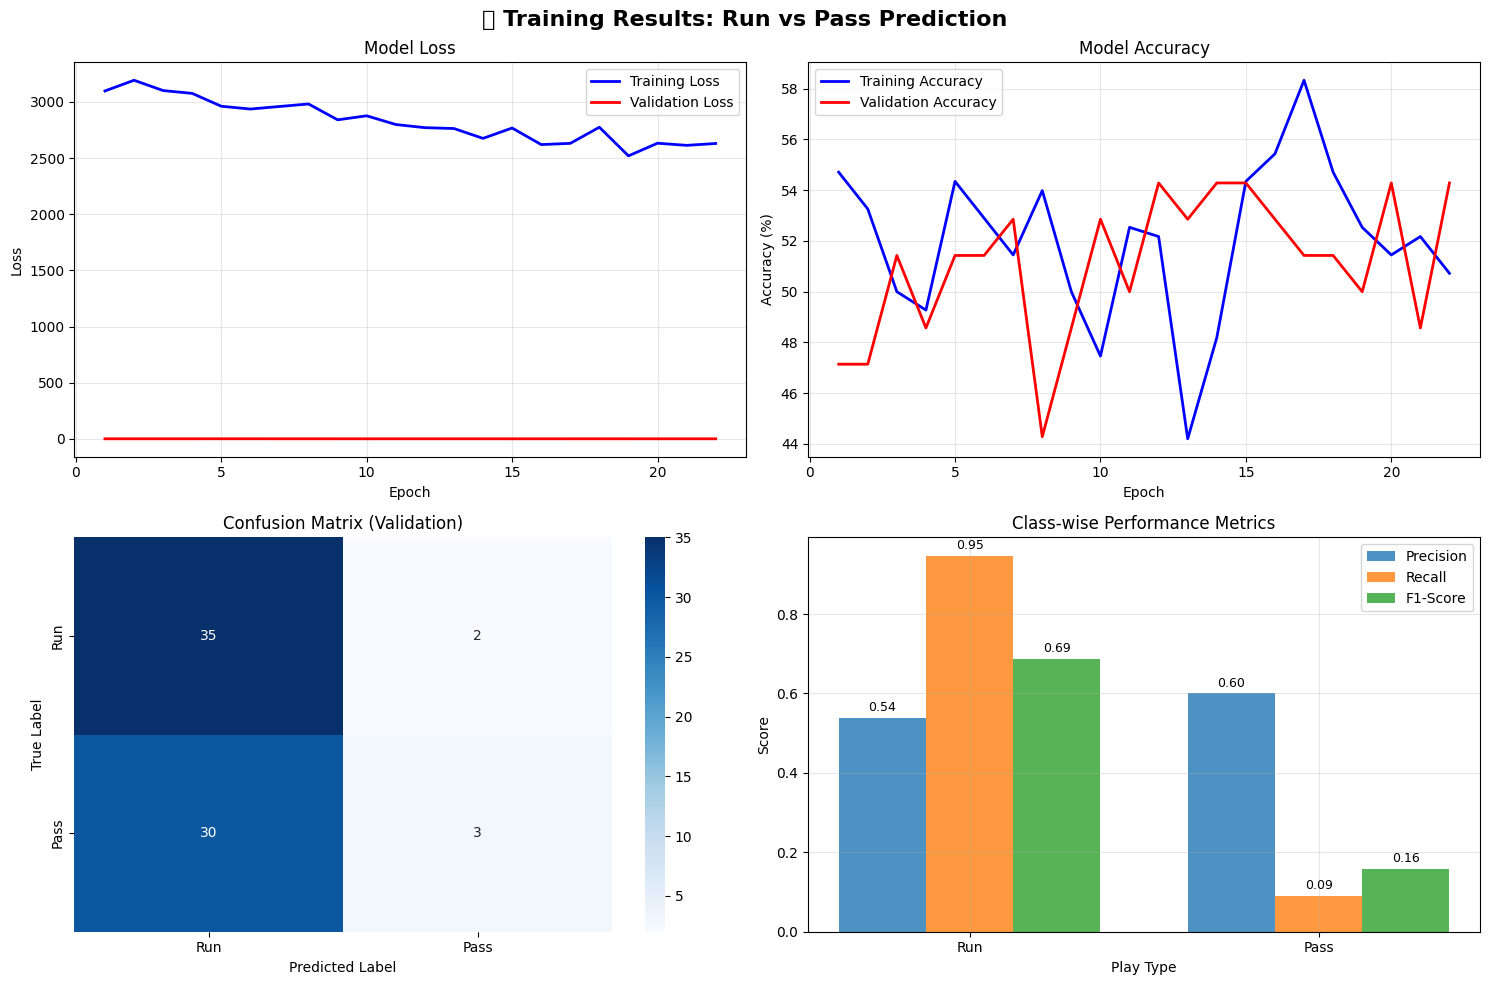

\n📈 FINAL PERFORMANCE METRICS
Best Validation Accuracy: 54.29%
Final Training Accuracy: 50.72%
Total Training Epochs: 22
\n🎯 Classification Report:
              precision    recall  f1-score   support

         Run       0.54      0.95      0.69        37
        Pass       0.60      0.09      0.16        33

    accuracy                           0.54        70
   macro avg       0.57      0.52      0.42        70
weighted avg       0.57      0.54      0.44        70



In [10]:
# TRAINING RESULTS VISUALIZATION
print("\\n📊 VISUALIZING TRAINING RESULTS")
print("-" * 40)

# Create training plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🏈 Training Results: Run vs Pass Prediction', fontsize=16, fontweight='bold')

epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Loss curves
axes[0,0].plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0,0].plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0,1].plot(epochs_range, train_accs, 'b-', label='Training Accuracy', linewidth=2)
axes[0,1].plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix
cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
           xticklabels=['Run', 'Pass'], yticklabels=['Run', 'Pass'])
axes[1,0].set_title('Confusion Matrix (Validation)')
axes[1,0].set_ylabel('True Label')
axes[1,0].set_xlabel('Predicted Label')

# Plot 4: Class-wise metrics
report = classification_report(val_labels, val_predictions, output_dict=True)
metrics_df = pd.DataFrame(report).T.iloc[:-3]  # Remove avg/weighted avg
metrics_df.index = ['Run', 'Pass']

x = np.arange(len(metrics_df.index))
width = 0.25

bars1 = axes[1,1].bar(x - width, metrics_df['precision'], width, label='Precision', alpha=0.8)
bars2 = axes[1,1].bar(x, metrics_df['recall'], width, label='Recall', alpha=0.8)
bars3 = axes[1,1].bar(x + width, metrics_df['f1-score'], width, label='F1-Score', alpha=0.8)

axes[1,1].set_title('Class-wise Performance Metrics')
axes[1,1].set_xlabel('Play Type')
axes[1,1].set_ylabel('Score')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(['Run', 'Pass'])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed metrics
print(f"\\n📈 FINAL PERFORMANCE METRICS")
print("=" * 40)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Total Training Epochs: {len(train_losses)}")

print(f"\\n🎯 Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=['Run', 'Pass']))


In [11]:
# MODEL INFERENCE AND PREDICTION EXAMPLES
print("\n🔮 TESTING MODEL PREDICTIONS")
print("-" * 40)

# Load the best model
checkpoint = torch.load('../models/best_play_predictor.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Best model loaded for inference")

def predict_play_type(model, image_path, features, device, feature_columns):
    """Predict play type for a single image"""
    model.eval()
    
    # Load and preprocess image
    if Path(image_path).exists():
        image = Image.open(image_path).convert('RGB')
        image = val_transform(image).unsqueeze(0).to(device)
    else:
        image = torch.zeros(1, 3, 224, 224).to(device)
    
    # Prepare features - handle pandas Series to numpy conversion issues
    # When accessing multiple columns from a pandas Series, it can return object dtype
    # even if individual columns are numeric
    try:
        # First attempt: direct conversion
        feature_values = features[feature_columns].values.astype(np.float64)
    except (ValueError, TypeError) as e:
        print(f"Direct conversion failed: {e}")
        # Fallback: convert each value individually 
        feature_list = []
        for col in feature_columns:
            val = features[col]
            # Handle different data types
            if pd.isna(val):
                feature_list.append(0.0)
            else:
                try:
                    feature_list.append(float(val))
                except (ValueError, TypeError):
                    print(f"Warning: Could not convert {col}={val} to float, using 0.0")
                    feature_list.append(0.0)
        feature_values = np.array(feature_list, dtype=np.float64)
    
    # Convert to tensor
    feature_tensor = torch.FloatTensor(feature_values).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image, feature_tensor)
        probabilities = torch.softmax(outputs['play_type'], dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        confidence = torch.max(probabilities, dim=1)[0]
    
    play_type = 'run' if predicted_class.item() == 0 else 'pass'
    confidence_score = confidence.item()
    
    return play_type, confidence_score, probabilities.cpu().numpy()[0]

# Test on some validation examples
print("\n🎲 Sample Predictions:")
print("-" * 30)

# Get random samples from validation set
sample_indices = np.random.choice(len(X_val), min(10, len(X_val)), replace=False)

for i, idx in enumerate(sample_indices[:5]):  # Show first 5
    row = X_val.iloc[idx]
    true_label = 'run' if row['label'] == 0 else 'pass'
    
    # Find image path
    image_path = None
    for base_path in image_base_paths:
        potential_path = Path(base_path) / row['filename']
        if potential_path.exists():
            image_path = str(potential_path)
            break
        # Try with images subfolder
        potential_path = Path(base_path) / "images" / row['filename']
        if potential_path.exists():
            image_path = str(potential_path)
            break
    
    if image_path:
        pred_type, confidence, probs = predict_play_type(
            model, image_path, row, device, feature_columns
        )
        
        correct = "✅" if pred_type == true_label else "❌"
        print(f"{i+1}. {row['filename'][:30]:30s} | True: {true_label:4s} | "
              f"Pred: {pred_type:4s} | Conf: {confidence:.3f} {correct}")
    else:
        print(f"{i+1}. {row['filename'][:30]:30s} | Image not found")

# Feature importance visualization
print(f"\n🧠 MODEL INSIGHTS")
print("-" * 20)

# Get a sample batch to analyze
sample_batch = next(iter(val_loader))
sample_images = sample_batch['image'][:4].to(device)
sample_features = sample_batch['features'][:4].to(device)
sample_labels = sample_batch['label'][:4]

with torch.no_grad():
    outputs = model(sample_images, sample_features)
    predictions = torch.softmax(outputs['play_type'], dim=1)

print(f"Sample batch predictions:")
for i in range(min(4, len(sample_labels))):
    true_label = 'run' if sample_labels[i] == 0 else 'pass'
    pred_probs = predictions[i].cpu().numpy()
    pred_label = 'run' if pred_probs[0] > pred_probs[1] else 'pass'
    confidence = max(pred_probs)
    
    correct = "✅" if pred_label == true_label else "❌"
    print(f"  Sample {i+1}: True={true_label:4s} | Pred={pred_label:4s} | "
          f"Conf={confidence:.3f} | Run={pred_probs[0]:.3f} Pass={pred_probs[1]:.3f} {correct}")

print(f"\n💾 Model saved and ready for production use!")
print(f"Model path: ../models/best_play_predictor.pth")
print(f"Features used: {len(feature_columns)} formation features + image data")



🔮 TESTING MODEL PREDICTIONS
----------------------------------------
✅ Best model loaded for inference

🎲 Sample Predictions:
------------------------------


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.